In [ ]:
import numpy as np
import sys
import os
import plotly.graph_objects as go

In [ ]:
sys.path.append(os.path.abspath(os.path.join(".", "..")))
import bssneqs as bssn
import tomllib
from nwave import *

In [ ]:
with open("idtest.toml", "rb") as f:
    params = tomllib.load(f)

In [5]:
# Set up grid
if "Xmin" in params and params["Xmin"] < 0.0:
    extended_domain = True
    cellgrid = False
    if params["Nx"] % 2 != 0:
        params["Nx"] += 1
        print(f"Adjusted Nx to {params['Nx']} (must be even)")
else:
    extended_domain = False
    cellgrid = True

nghost = params["NGhost"]
g = Grid1D(params, cell_centered=cellgrid)

In [6]:
r = g.xi[0]
dr = g.dx[0]
if params["D1"] == "E4":
    D1 = ExplicitFirst44_1D(dr)
    g.set_D1(D1)
elif params["D1"] == "E6":
    D1 = ExplicitFirst642_1D(dr)
    g.set_D1(D1)
elif params["D1"] == "JP6":
    #D1 = CompactFirst1D(r, "D1_JTP6", method="LUSOLVE")
    D1 = CompactFirst1D(r, "D1_JTP6", method="SCIPY")
    g.set_D1(D1)
elif params["D1"] == "KP4":
    # D1 = CompactFirst1D(r, "D1_KP4", method="LUSOLVE")
    D1 = CompactFirst1D(r, "D1_KP4", method="SCIPY")
    g.set_D1(D1)
else:
    raise NotImplementedError("D1 = { E4, E6, JP6, KP4 }")

In [7]:
if params["D2"] == "E4":
    D2 = ExplicitSecond44_1D(dr)
    g.set_D2(D2)
elif params["D2"] == "E6":
    D2 = ExplicitSecond642_1D(dr)
    g.set_D2(D2)
elif params["D2"] == "JP6":
    # D2 = CompactSecond1D(r, "D2_JTP6", method="LUSOLVE")
    D2 = CompactSecond1D(r, "D2_JTP6", method="LUSOLVE")
    g.set_D2(D2)
else:
    raise NotImplementedError("D2 = { E4, E6, JP6 }")

In [8]:
if "Filter" in params:
    sigma = params.get("KOsigma", 0.1)
    apply_diss_boundaries = params.get("ApplyDissBounds", False)
    if params["Filter"] == "KO6":
        bssn_filter = KreissOligerFilterO6_1D(dr, sigma, apply_diss_boundaries)
        g.set_filter(bssn_filter)
    elif params["Filter"] == "KO8":
        bssn_filter = KreissOligerFilterO8_1D(dr, sigma, apply_diss_boundaries=True)
        g.set_filter(bssn_filter)
    else:
        raise NotImplementedError("Filter = { KO6, KO8 }")

In [9]:
# GBSSN system: (sys, lapse advection, shift advection)
#    sys = 0 (Eulerian), 1 (Lagrangian)
sys = bssn.GBSSNSystem(1, 1, 1)
eqs = bssn.BSSN(
    g, params["Mass"], params["eta"], extended_domain, "FUNCTION", sys, have_d2=True
)
eqs.initialize(g, params)

eqs.cal_constraints(eqs.u, g)

In [10]:
ED1 = ExplicitFirst642_1D(dr)
ED2 = ExplicitSecond642_1D(dr)

In [11]:
ed_chi = ED1.grad(eqs.u[eqs.U_CHI])
ed_g_rr = ED1.grad(eqs.u[eqs.U_GRR])
ed_g_tt = ED1.grad(eqs.u[eqs.U_GTT])
ed_A_rr = ED1.grad(eqs.u[eqs.U_ARR])
ed_K = ED1.grad(eqs.u[eqs.U_K])
ed2_chi = ED2.grad2(eqs.u[eqs.U_CHI])
ed2_g_tt = ED2.grad2(eqs.u[eqs.U_GTT])

In [12]:
d_chi = D1.grad(eqs.u[eqs.U_CHI])
d_g_rr = D1.grad(eqs.u[eqs.U_GRR])
d_g_tt = D1.grad(eqs.u[eqs.U_GTT])
d_A_rr = D1.grad(eqs.u[eqs.U_ARR])
d_K = D1.grad(eqs.u[eqs.U_K])
d2_chi = D2.grad2(eqs.u[eqs.U_CHI])
d2_g_tt = D2.grad2(eqs.u[eqs.U_GTT])

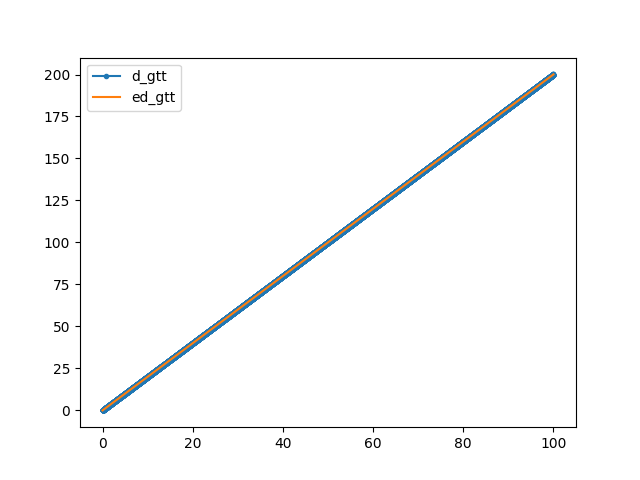

In [25]:
fig, ax = plt.subplots()
ax.plot(r,d_g_tt,'.-',label='d_gtt')
ax.plot(r,ed_g_tt,'-',label='ed_gtt')
ax.legend()

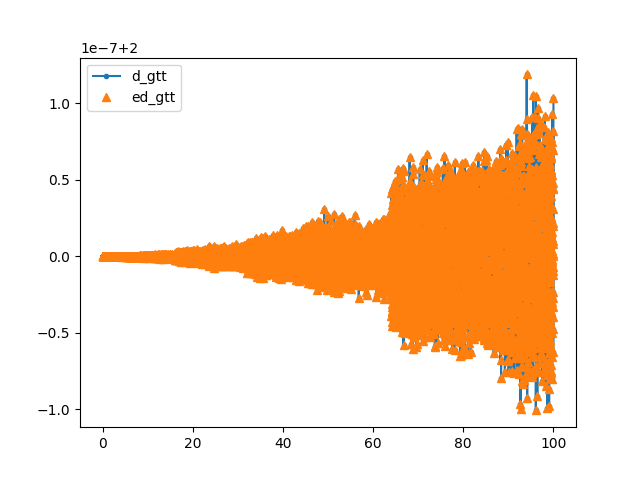

In [26]:
fig, ax = plt.subplots()
ax.plot(r,d2_g_tt,'.-',label='d_gtt')
ax.plot(r,ed2_g_tt,'^',label='ed_gtt')
ax.legend()

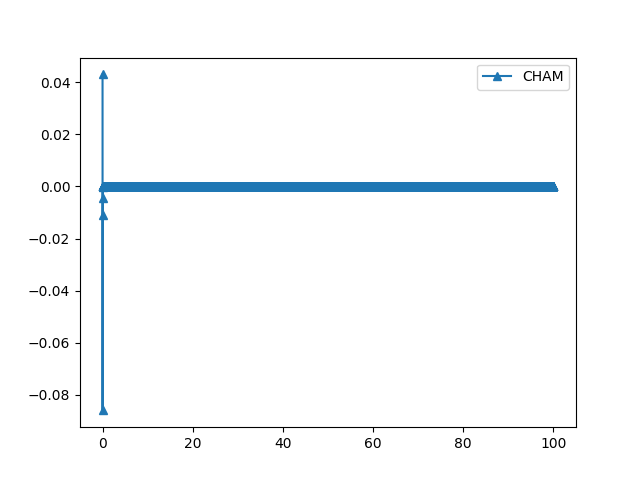

In [27]:
fig, ax = plt.subplots()
ax.plot(r, eqs.C[eqs.C_HAM],'^-',label='CHAM')
ax.legend()

In [16]:
nx = params["Nx"]
alpha = 0.4
beta = 0.4
fbound = True
Pb, Q, bands = init_JT_filter(FilterType.JTP8, alpha, beta, fbound, nx)

In [17]:
Pb

array([[0. , 0. , 0.4, ..., 0.4, 0.4, 0.4],
       [0. , 0.4, 0.4, ..., 0.4, 0.4, 0.4],
       [1. , 1. , 1. , ..., 1. , 1. , 1. ],
       [0.4, 0.4, 0.4, ..., 0.4, 0.4, 0. ],
       [0.4, 0.4, 0.4, ..., 0.4, 0. , 0. ]], shape=(5, 10000))

In [18]:
Q

array([[0.99609375, 0.40234375, 0.39609375, ..., 0.        , 0.        ,
        0.        ],
       [0.43125   , 0.98125   , 0.43125   , ..., 0.        , 0.        ,
        0.        ],
       [0.290625  , 0.465625  , 0.890625  , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.890625  , 0.465625  ,
        0.290625  ],
       [0.        , 0.        , 0.        , ..., 0.43125   , 0.98125   ,
        0.43125   ],
       [0.        , 0.        , 0.        , ..., 0.39609375, 0.40234375,
        0.99609375]], shape=(10000, 10000))

In [19]:
banded_to_full(Pb, 2, 2, nx, nx)

array([[1. , 0.4, 0.4, ..., 0. , 0. , 0. ],
       [0.4, 1. , 0.4, ..., 0. , 0. , 0. ],
       [0.4, 0.4, 1. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 1. , 0.4, 0.4],
       [0. , 0. , 0. , ..., 0.4, 1. , 0.4],
       [0. , 0. , 0. , ..., 0.4, 0.4, 1. ]], shape=(10000, 10000))

In [20]:
f = 1/r

In [21]:
fn = f + 0.001*np.sin(100.0*r)

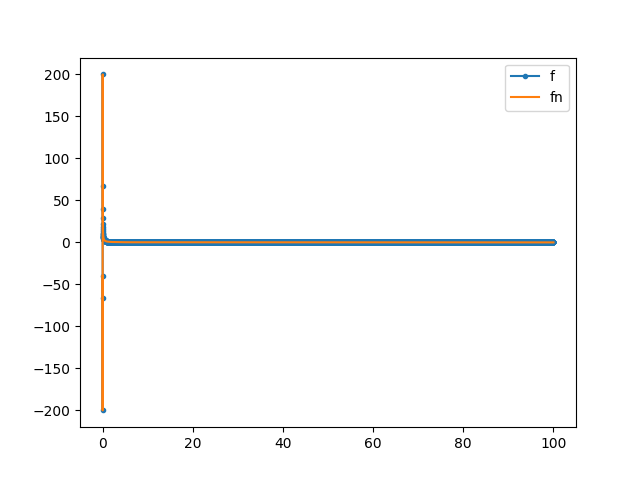

In [30]:
fig, ax = plt.subplots()
ax.plot(r, f, '.-',label='f')
ax.plot(r, fn,label='fn')
ax.legend()